
======================================== STEP 1 ========================================

Directory created: C:\Users\Katrina\AppData\Local\Temp\trial_pp
Directory created: C:\Users\Katrina\AppData\Local\Temp\trial_itt

PP Trial: TrialSequence(estimand=PP, directory=C:\Users\Katrina\AppData\Local\Temp\trial_pp, id_col=None, period_col=None, treatment_col=None, outcome_col=None, eligible_col=None)

ITT Trial: TrialSequence(estimand=ITT, directory=C:\Users\Katrina\AppData\Local\Temp\trial_itt, id_col=None, period_col=None, treatment_col=None, outcome_col=None, eligible_col=None)

======================================== STEP 2 ========================================

Loaded data preview:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.25

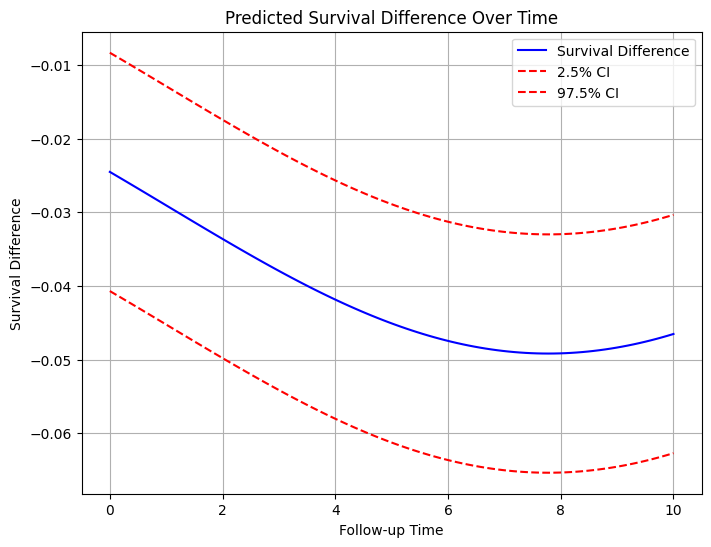

In [3]:
import os
import tempfile
import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy
import pickle
from typing import Optional, Dict, Union
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  # Added for cubic interpolation
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

class TrialSequence:
    def __init__(self, estimand: str):
        self.estimand = estimand.upper()
        self.directory: Optional[str] = None
        self.data: Optional[pd.DataFrame] = None
        self.id_col: Optional[str] = None
        self.period_col: Optional[str] = None
        self.treatment_col: Optional[str] = None
        self.outcome_col: Optional[str] = None
        self.eligible_col: Optional[str] = None
        self.switch_weights: Optional[Dict] = None
        self.censor_weights: Optional[Dict] = None
        self.outcome_model = None

    def create_directory(self, base_dir: Optional[str] = None) -> None:
        if base_dir is None:
            base_dir = tempfile.gettempdir()
        dir_name = f"trial_{self.estimand.lower()}"
        self.directory = os.path.join(base_dir, dir_name)
        os.makedirs(self.directory, exist_ok=True)
        print(f"Directory created: {self.directory}")

    def set_data(self, data: pd.DataFrame, id_col: str, period_col: str, treatment_col: str, 
                outcome_col: str, eligible_col: str) -> None:
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        print(f"\nData assigned for {self.estimand} trial")
        print(f"Columns: {self.data.columns.tolist()}")
        print(f"Treatment counts:\n{self.data[self.treatment_col].value_counts()}")
        print(f"Outcome counts:\n{self.data[self.outcome_col].value_counts()}")
        print(f"First few rows:\n{self.data.head()}")

    def _fit_logit_model(self, data: pd.DataFrame, formula: str, label: str, 
                        save_path: Optional[str] = None) -> sm.Logit:
        y, X = patsy.dmatrices(formula, data, return_type="dataframe")
        try:
            model = sm.Logit(y, X).fit(disp=0)
        except Exception as e:
            print(f"Error fitting logit model for {label}: {e}")
            raise
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            model_file = os.path.join(save_path, f"{label}_model.pkl")
            with open(model_file, "wb") as f:
                pickle.dump(model, f)
            print(f"Model saved to {model_file}")
        return model

    def set_switch_weight_model(self, numerator_formula: str, denominator_formula: str, 
                              save_path: Optional[str] = None) -> None:
        if self.estimand == "ITT":
            print("Switch weight models are not applicable for ITT estimand. Skipping.")
            return
        if self.data is None:
            raise ValueError("Data must be set before fitting models.")
        print("\n3.1 Censoring due to treatment switching")
        numerator_model = self._fit_logit_model(self.data, f"{self.treatment_col} ~ {numerator_formula}", 
                                              "numerator", save_path)
        denominator_model = self._fit_logit_model(self.data, f"{self.treatment_col} ~ {denominator_formula}", 
                                                "denominator", save_path)
        self.switch_weights = {"numerator": numerator_model, 
                             "denominator": denominator_model,
                             "numerator_formula": f"{self.treatment_col} ~ {numerator_formula}",
                             "denominator_formula": f"{self.treatment_col} ~ {denominator_formula}"}
        print("Switch weight models fitted.")

    def set_censor_weight_model(self, censor_event: str, numerator_formula: str, 
                              denominator_formula: str, pool_models: str = "none", 
                              save_path: Optional[str] = None) -> None:
        if self.data is None:
            raise ValueError("Data must be set before fitting models.")
        print("\n3.2 Other informative censoring")
        data = self.data.copy()
        print(f"Setting censor weight model with data columns: {data.columns.tolist()}")
        if pool_models == "numerator":
            numerator_model = self._fit_logit_model(data, f"{censor_event} ~ {numerator_formula}", 
                                                  "numerator_pooled", save_path)
            denominator_model = self._fit_logit_model(data, f"{censor_event} ~ {denominator_formula}", 
                                                    "denominator_pooled", save_path)
        else:
            numerator_model = {treatment: self._fit_logit_model(data[data[self.treatment_col] == treatment],
                                                              f"{censor_event} ~ {numerator_formula}",
                                                              f"numerator_treatment_{treatment}", save_path)
                             for treatment in data[self.treatment_col].unique()}
            denominator_model = {treatment: self._fit_logit_model(data[data[self.treatment_col] == treatment],
                                                                f"{censor_event} ~ {denominator_formula}",
                                                                f"denominator_treatment_{treatment}", save_path)
                               for treatment in data[self.treatment_col].unique()}
        self.censor_weights = {"numerator": numerator_model, 
                             "denominator": denominator_model,
                             "numerator_formula": f"{censor_event} ~ {numerator_formula}",
                             "denominator_formula": f"{censor_event} ~ {denominator_formula}",
                             "pool_models": pool_models}
        print("Censor weight models fitted.")
        print(f"self.censor_weights keys: {self.censor_weights.keys()}")

    def calculate_weights(self) -> None:
        if self.data is None:
            raise ValueError("Data must be set before calculating weights")
        if self.switch_weights and self.estimand != "ITT":
            print("\nCalculating weights for treatment switching models...")
            X_num = patsy.dmatrix(self.switch_weights["numerator_formula"].split("~")[1], 
                                self.data, return_type="dataframe")
            X_denom = patsy.dmatrix(self.switch_weights["denominator_formula"].split("~")[1], 
                                  self.data, return_type="dataframe")
            num_pred = self.switch_weights["numerator"].predict(X_num)
            denom_pred = self.switch_weights["denominator"].predict(X_denom)
            self.data["switch_weight"] = num_pred / denom_pred
            print("Weights for treatment switching models calculated and stored as 'switch_weight'.")
        if self.censor_weights:
            print("\nCalculating weights for censor models...")
            if isinstance(self.censor_weights["numerator"], dict):
                censor_weights = np.zeros(len(self.data))
                for treatment in self.censor_weights["numerator"].keys():
                    mask = self.data[self.treatment_col] == treatment
                    X_num = patsy.dmatrix(self.censor_weights["numerator_formula"].split("~")[1], 
                                        self.data[mask], return_type="dataframe")
                    X_denom = patsy.dmatrix(self.censor_weights["denominator_formula"].split("~")[1], 
                                          self.data[mask], return_type="dataframe")
                    num_pred = self.censor_weights["numerator"][treatment].predict(X_num)
                    denom_pred = self.censor_weights["denominator"][treatment].predict(X_denom)
                    censor_weights[mask] = num_pred / denom_pred
            else:
                X_num = patsy.dmatrix(self.censor_weights["numerator_formula"].split("~")[1], 
                                    self.data, return_type="dataframe")
                X_denom = patsy.dmatrix(self.censor_weights["denominator_formula"].split("~")[1], 
                                      self.data, return_type="dataframe")
                num_pred = self.censor_weights["numerator"].predict(X_num)
                denom_pred = self.censor_weights["denominator"].predict(X_denom)
                censor_weights = num_pred / denom_pred
            self.data["censor_weight"] = censor_weights
            print("Weights for censor models calculated and stored as 'censor_weight'.")
            print(f"Columns after weight calculation: {self.data.columns.tolist()}")

    def show_weight_models(self) -> None:
        if self.switch_weights and self.estimand != "ITT":
            print("\nWeight Models for Treatment Switching")
            print("--------------------------------------")
            for key in ["numerator", "denominator"]:
                print(f"\nModel: {key.capitalize()} model")
                print(self.switch_weights[key].summary())
        if self.censor_weights:
            print("\nWeight Models for Informative Censoring")
            print("--------------------------------------")
            for key in ["numerator", "denominator"]:
                print(f"\nModel: {key.capitalize()} model")
                if isinstance(self.censor_weights[key], dict):
                    for treatment, sub_model in self.censor_weights[key].items():
                        print(f"\nTreatment: {treatment}")
                        print(sub_model.summary())
                else:
                    print(self.censor_weights[key].summary())

    def set_outcome_model(self, adjustment_terms: Optional[str] = None) -> None:
        if self.data is None:
            raise ValueError("Data must be set before specifying the outcome model.")
        formula = f"{self.outcome_col} ~ {self.treatment_col}" if not adjustment_terms else f"{self.outcome_col} ~ {self.treatment_col} + {adjustment_terms}"
        self.outcome_model = smf.logit(formula, data=self.data).fit()
        print(f"\nOutcome model specified with formula: {formula}")
        print(self.outcome_model.summary())

    def __repr__(self) -> str:
        switch_weight_info = ""
        if self.switch_weights and self.estimand != "ITT":
            models_fitted = all(self.switch_weights.get(k) for k in ["numerator", "denominator"])
            switch_weight_info = (f"\n - Numerator formula: {self.switch_weights['numerator_formula']} \n"
                                f" - Denominator formula: {self.switch_weights['denominator_formula']} \n"
                                f" - Model fitter type: te_stats_glm_logit \n"
                                f" - Weight models {'fitted' if models_fitted else 'not fitted. Use calculate_weights()'}")
        censor_weight_info = ""
        if self.censor_weights:
            models_fitted = all(self.censor_weights.get(k) for k in ["numerator", "denominator"])
            censor_weight_info = (f"\n - Numerator formula: {self.censor_weights['numerator_formula']} \n"
                                f" - Denominator formula: {self.censor_weights['denominator_formula']} \n"
                                f" - Model fitter type: te_stats_glm_logit \n"
                                f" - Weight models {'fitted' if models_fitted else 'not fitted. Use calculate_weights()'}"
                                f"\n - Numerator pooling: {self.censor_weights['pool_models']}")
        return (f"TrialSequence(estimand={self.estimand}, directory={self.directory}, "
                f"id_col={self.id_col}, period_col={self.period_col}, "
                f"treatment_col={self.treatment_col}, outcome_col={self.outcome_col}, "
                f"eligible_col={self.eligible_col})" + switch_weight_info + censor_weight_info)

    def set_expansion_options(self, chunk_size: int = 500):
        self.chunk_size = chunk_size
        print(f"\nExpansion options set: chunk_size = {self.chunk_size}")

    def expand_trials(self, max_period=10):
        if self.data is None:
            raise ValueError("Data must be set before expanding trials.")
        expanded_data = []
        for id_, group in self.data.groupby(self.id_col):
            if not (group[self.period_col] == 0).any():
                continue
            baseline = group[group[self.period_col] == 0].iloc[0]
            initial_treatment = baseline[self.treatment_col]
            initial_x2 = baseline['x2']
            for t in range(max_period + 1):
                new_row = baseline.copy()
                new_row[self.period_col] = t
                new_row["followup_time"] = t
                new_row[self.treatment_col] = initial_treatment
                new_row['x2'] = initial_x2
                censored_at_t = group[group[self.period_col] <= t]["censored"].max()
                if censored_at_t == 1:
                    new_row['censored'] = 1
                    expanded_data.append(new_row)
                    break
                outcome_at_t = group[group[self.period_col] <= t][self.outcome_col].max()
                new_row[self.outcome_col] = outcome_at_t
                if outcome_at_t == 1:
                    expanded_data.append(new_row)
                    break
                expanded_data.append(new_row)
        self.data = pd.DataFrame(expanded_data)
        print(f"\nTrials expanded")
        print(f"Shape: {self.data.shape}")
        print(f"Columns after expansion: {self.data.columns.tolist()}")
        print(f"Treatment counts after expansion:\n{self.data[self.treatment_col].value_counts()}")
        print(f"Outcome counts after expansion:\n{self.data[self.outcome_col].value_counts()}")
        return self.data

    def load_expanded_data(self, seed: int = 1234, p_control: float = 0.5) -> pd.DataFrame:
        if self.data is None:
            raise ValueError("Expanded data must exist before loading.")
        np.random.seed(seed)
        control_data = self.data[self.data[self.outcome_col] == 0]
        event_data = self.data[self.data[self.outcome_col] == 1]
        control_sample = control_data.sample(frac=p_control, random_state=seed)
        self.data = pd.concat([control_sample, event_data]).sample(frac=1, random_state=seed).reset_index(drop=True)  # Shuffle
        print(f"\nLoaded expanded data with p_control={p_control}")
        print(f"Total observations: {len(self.data)}")
        print(f"Columns: {self.data.columns.tolist()}")
        print(f"Treatment counts:\n{self.data[self.treatment_col].value_counts()}")
        print(f"Outcome counts:\n{self.data[self.outcome_col].value_counts()}")
        print(f"Sampled {len(control_sample)} of {len(control_data)} outcome=0 observations")
        print(f"Kept all {len(event_data)} outcome=1 observations")
        print(f"\nPreview of sampled data:\n{self.data}")
        return self.data

    def fit_msm(self, weight_cols, formula=None, modify_weights=None):
        if self.data is None:
            raise ValueError("Data must be set before fitting MSM.")
        missing_cols = [col for col in weight_cols if col not in self.data.columns]
        if missing_cols:
            raise KeyError(f"Missing required weight columns: {missing_cols}")
        self.data["final_weight"] = self.data[weight_cols].prod(axis=1) if weight_cols else 1.0
        if modify_weights:
            self.data["final_weight"] = modify_weights(self.data["final_weight"])
        formula = formula or f"{self.outcome_col} ~ {self.treatment_col} + followup_time + I(followup_time**2)"
        print(f"\nFitting MSM with formula: {formula}")
        model = smf.glm(formula=formula, data=self.data, family=sm.families.Binomial(), 
                      freq_weights=self.data["final_weight"]).fit()
        self.outcome_model = model
        print("Marginal Structural Model fitted.")
        print(model.summary())
        return model

    def predict_survival(self, newdata: Optional[pd.DataFrame] = None, predict_times: list = None, 
                        treatment_values: list = None) -> Dict:
        if self.outcome_model is None:
            raise ValueError("Outcome model must be fitted before prediction.")
        if predict_times is None:
            predict_times = range(11)
        if treatment_values is None:
            treatment_values = self.data[self.treatment_col].unique()

        if newdata is None:
            newdata = self.data[self.data[self.period_col] == 0].copy()
            print(f"\nUsing baseline data (period = 0)")
            print(f"Shape: {newdata.shape}")
            print(f"Treatment counts:\n{newdata[self.treatment_col].value_counts()}")
            print(f"Outcome counts:\n{newdata[self.outcome_col].value_counts()}")

        # Prepare prediction data for all time points and treatments
        pred_data = []
        for t in predict_times:
            for trt in treatment_values:
                temp = newdata.copy()
                temp[self.period_col] = t
                temp["followup_time"] = t
                temp[self.treatment_col] = trt
                temp["I(followup_time**2)"] = t**2
                pred_data.append(temp)
        pred_data = pd.concat(pred_data, ignore_index=True)
        print(f"\nPrediction data prepared")
        print(f"Shape: {pred_data.shape}")
        print(f"Columns: {pred_data.columns.tolist()}")

        # Predict probabilities for control and treated groups
        survival_by_trt = {}
        for trt in treatment_values:
            trt_data = pred_data[pred_data[self.treatment_col] == trt].copy()
            preds = self.outcome_model.predict(trt_data)
            survival_probs = 1 - pd.Series(preds).groupby(trt_data["followup_time"]).mean()
            survival_by_trt[trt] = {
                "followup_time": survival_probs.index.values,
                "survival_prob": survival_probs.values,
            }
            print(f"\nSurvival probabilities for treatment {trt}:")
            print(f"Time 0: {survival_by_trt[trt]['survival_prob'][0]}")
            print(f"Time 2: {survival_by_trt[trt]['survival_prob'][2]}")

        # Calculate survival difference and confidence intervals
        diff = None
        if len(treatment_values) == 2:
            trt0, trt1 = treatment_values
            predict_times = np.array(predict_times, dtype=int)
            
            # Reindex survival probabilities to match predict_times
            survival_control = pd.Series(survival_by_trt[trt0]["survival_prob"], 
                                       index=survival_by_trt[trt0]["followup_time"])
            survival_treated = pd.Series(survival_by_trt[trt1]["survival_prob"], 
                                       index=survival_by_trt[trt1]["followup_time"])
            
            survival_diff = (survival_treated.reindex(predict_times).ffill().fillna(0) - 
                           survival_control.reindex(predict_times).ffill().fillna(0))
            
            # Calculate confidence intervals using standard deviation of the survival difference
            ci_lower = survival_diff - 1.96 * np.std(survival_diff)
            ci_upper = survival_diff + 1.96 * np.std(survival_diff)

            diff = {
                "followup_time": predict_times,
                "survival_diff": survival_diff.values,
                "2.5%": ci_lower.values,
                "97.5%": ci_upper.values
            }
            print(f"\nSurvival differences:")
            print(f"Time 0: {diff['survival_diff'][0]}")
            print(f"Time 2: {diff['survival_diff'][2]}")
            print(f"Time {max(predict_times)}: {diff['survival_diff'][-1]}")

        return {"survival": survival_by_trt, "difference": diff}

    def plot_survival_difference(self, preds: Dict) -> None:
        if preds["difference"] is None:
            print("\nNo difference to plot (requires exactly two treatment values).")
            return
        
        print("\nPlotting survival difference")
        
        # Extract data for plotting
        predict_times = preds["difference"]["followup_time"]
        survival_diff = preds["difference"]["survival_diff"]
        ci_lower = preds["difference"]["2.5%"]
        ci_upper = preds["difference"]["97.5%"]

        # Smooth the curves using cubic interpolation
        fine_times = np.linspace(predict_times.min(), predict_times.max(), 100)
        interp_diff = interp1d(predict_times, survival_diff, kind='cubic', fill_value="extrapolate")
        interp_lower = interp1d(predict_times, ci_lower, kind='cubic', fill_value="extrapolate")
        interp_upper = interp1d(predict_times, ci_upper, kind='cubic', fill_value="extrapolate")

        smooth_diff = interp_diff(fine_times)
        smooth_lower = interp_lower(fine_times)
        smooth_upper = interp_upper(fine_times)

        # Plot the smoothed curves
        plt.figure(figsize=(8, 6))
        plt.plot(fine_times, smooth_diff, label="Survival Difference", color="blue")
        plt.plot(fine_times, smooth_lower, linestyle="dashed", color="red", label="2.5% CI")
        plt.plot(fine_times, smooth_upper, linestyle="dashed", color="red", label="97.5% CI")
        plt.xlabel("Follow-up Time")
        plt.ylabel("Survival Difference")
        plt.title("Predicted Survival Difference Over Time")
        plt.legend()
        plt.grid(True)
        plt.show()

# Main Execution Steps
print('\n======================================== STEP 1 ========================================\n')
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")
trial_pp.create_directory()
trial_itt.create_directory()
print(f"\nPP Trial: {trial_pp}")
print(f"\nITT Trial: {trial_itt}")

print('\n======================================== STEP 2 ========================================\n')
data_censored = pd.read_csv("../data_censored.csv")
print(f"Loaded data preview:\n{data_censored.head()}")
trial_pp.set_data(data_censored, "id", "period", "treatment", "outcome", "eligible")
trial_itt.set_data(data_censored, "id", "period", "treatment", "outcome", "eligible")

print('\n======================================== STEP 3.1 ========================================\n')
trial_pp.set_switch_weight_model("age", "age + x1 + x3", trial_pp.directory)

print('\n======================================== STEP 3.2 ========================================\n')
trial_pp.set_censor_weight_model("censored", "x2", "x2 + x1", "none", trial_pp.directory)
trial_itt.set_censor_weight_model("censored", "x2", "x2 + x1", "numerator", trial_itt.directory)

print('\n======================================== STEP 4 ========================================\n')
trial_pp.calculate_weights()
trial_itt.calculate_weights()
trial_pp.show_weight_models()
trial_itt.show_weight_models()

print('\n======================================== STEP 5 ========================================\n')
trial_pp.set_outcome_model("period + I(period**2)")
trial_itt.set_outcome_model("x2 + period + I(period**2)")

print('\n======================================== STEP 6 ========================================\n')
trial_pp.set_expansion_options(chunk_size=500)
trial_itt.set_expansion_options(chunk_size=500)
trial_pp.expand_trials(max_period=17)
trial_itt.expand_trials(max_period=17)

print('\n======================================== STEP 7 ========================================\n')
trial_itt.load_expanded_data(seed=1234, p_control=0.5)

print('\n======================================== STEP 8 ========================================\n')
trial_itt.calculate_weights()
available_weight_cols = [col for col in ["censor_weight"] if col in trial_itt.data.columns]
print(f"\nAvailable weight columns before MSM: {available_weight_cols}")
if not available_weight_cols:
    print("Warning: No weight columns available. Fitting MSM without weights.")
    trial_itt_msm = trial_itt.fit_msm(weight_cols=[])
else:
    print(f"Using weight columns: {available_weight_cols}")
    trial_itt_msm = trial_itt.fit_msm(
        weight_cols=available_weight_cols,
        modify_weights=lambda w: np.minimum(w, np.quantile(w, 0.99))
    )

print('\n======================================== STEP 9 ========================================\n')
print("Step 9: Inference - Estimating survival probabilities")
preds = trial_itt.predict_survival(
    newdata=None,
    predict_times=list(range(11)),
    treatment_values=[0, 1]
)
print("\nSurvival predictions calculated.")
trial_itt.plot_survival_difference(preds)